In [436]:
import numpy as np
import pandas as pd
from os.path import join as joinpath
from math import pow, log 
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [466]:
notespath_list = "/Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS/Da_po_zoriushke_1/PP/Da_po_zoriushke_1__PP__notes.csv",\
"/Users/polinap/Yandex.Disk.localized/RESEARCH_RU/VOCAL_NOTES_PROJECT/RUSSIAN/ANALYSIS/Da_po_zoriushke_1/OV/Da_po_zoriushke_1__OV__notes.csv"

In [438]:
def read_from_csv(notespath):
    notes = pd.read_csv(notespath, header=None) # doesn't read headers

    # remove columns beyond the first three
    if len(notes.columns) > 3:
        notes = notes.iloc[:,:3]

    # remove headers
    if notes.iloc[0,0]=="TIME":
        notes = notes.iloc[1:,:]
        notes.reset_index(drop=True, inplace=True)

    notes.columns = ['TIME', 'VALUE', 'DURATION']
    
    notes['VALUE'] = notes['VALUE'].astype(float)

    return notes

notes_list = []
pitches_list = []
durations_list = []
for notespath in notespath_list:
    notes = read_from_csv(notespath)
    notes_list.append(notes)
    pitches_list.append(notes['VALUE'].astype(float).to_numpy())
    durations_list.append(notes['DURATION'].astype(float).to_numpy())

            TIME    VALUE     DURATION
0    0.685714286  314.455  0.690793651
1    1.442539683  237.279  0.177777778
2    1.620317460  236.325  0.391111111
3    2.011428571  352.063  0.421587302
4    2.438095238  320.555  0.126984127
..           ...      ...          ...
63  32.153832200  352.063  0.259047619
64  37.445079365  323.620  1.272380952
65  38.717460317  358.461  1.033650794
66  39.756190476  356.816  0.245986395
67  40.002176871  359.802  0.571791383

[68 rows x 3 columns]
            TIME    VALUE     DURATION
0    0.757551020  314.404  0.635646259
1    1.469387755  237.391  0.191564626
2    1.660952381  236.258  0.398367347
3    2.065850340  349.713  0.387482993
4    2.455510204  307.765  0.124081633
..           ...      ...          ...
68  37.437460317  294.470  0.149841270
69  37.587301587  323.857  1.092063492
70  38.679365079  358.324  1.069206349
71  39.816417234  356.816  0.156734694
72  40.054421769  359.802  0.516643991

[73 rows x 3 columns]


In [439]:
# calculate the tonal centre for a joint of both transcriptions
note_pitch_array = np.concatenate(pitches_list)
note_dur_array = np.concatenate(durations_list)

# get the last occurence of the longest note - the first approximation for the tonal centre
durations_reversed = note_dur_array[::-1]
longest_note_idx = len(durations_reversed) - np.argmax(durations_reversed) - 1
longest_note_pitch = note_pitch_array[longest_note_idx]
print("longest note frequency: ", longest_note_pitch)

# convert note pitches into cents relative to the longest note pitch
def pitch2cent(hertz_from, hertz_to):
    # hertz_from > hertz_to will return a negative value
    return round(1200*log(hertz_to/hertz_from,2))

def pitch2interval_func(tonal_centre):
    # construct a function which takes a pitch and returns the interval to tonal centre
    return lambda pitch: pitch2cent(tonal_centre, pitch)

pitch2interval = pitch2interval_func(longest_note_pitch) # this function only has one argument
pitch2interval_v = np.vectorize(pitch2interval) # vectorise to be able to apply to each element of an array
note_cents_array = pitch2interval_v(note_pitch_array)

longest note frequency:  323.62


In [440]:
# find histogram peak of notes in cents - a better approximation of the tonal centre
mybins = 60
h, hedges = np.histogram(note_cents_array, bins=mybins)

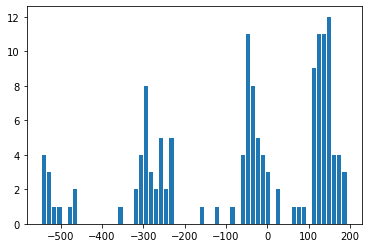

In [441]:
# plot the histogram for the join of both transcriptions
plt.bar(hedges[:-1],h, width=10, align='edge')
plt.show()

In [442]:
peaks, _ = find_peaks(h, distance=5, prominence=2)
estimated_tonal_centre = hedges[peaks[h[peaks].argmax()]]
estimated_tonal_centre_pitch = pow(2, estimated_tonal_centre/1200)*longest_note_pitch
print("estimated tonal centre: ", estimated_tonal_centre, " cents from the longest note")
print("estimated tonal centre frequency: ", estimated_tonal_centre_pitch)

estimated tonal centre:  144.73333333333335  cents from the longest note
estimated tonal centre frequency:  351.8381397480538


In [443]:
# change the tonal centre if needed
tonal_centre_frequency = estimated_tonal_centre_pitch
print("tonal centre frequency: ", tonal_centre_frequency)
tonal_centre_cents = pitch2cent(longest_note_pitch, tonal_centre_frequency)

# recalculate notes relative to the new tonal centre
note_cents_array = note_cents_array - tonal_centre_cents


tonal centre frequency:  351.8381397480538


In [444]:
# substitute note frequencies by notes in cents in the dataframes
for notes, pitches in zip(notes_list, pitches_list):
    cents = note_cents_array[0:len(pitches)]
    notes['VALUE'] = pd.Series(cents)
    note_cents_array = note_cents_array[len(pitches):]

In [445]:
# write to file
tc_string = str('%.2f' %tonal_centre_frequency)

for notes, notespath in zip(notes_list, notespath_list):
    fileout = notespath.replace("notes", "notes_cents_tc"+tc_string)
    notes.to_csv(fileout, index = False)

In [446]:
# convert segments files into cents
#segmentspath1 = notespath1.replace("notes", "segments")
segmentspath_list = [x.replace("notes", "segments") for x in notespath_list]

segments_list = []
for segmentspath in segmentspath_list:
    segments = read_from_csv(segmentspath)
    segments_list.append(segments)

pitch2interval = pitch2interval_func(tonal_centre_frequency)
for segments in segments_list:
    segments['VALUE'] = segments.VALUE.map(pitch2interval)
    
for segments, segmentspath in zip(segments_list, segmentspath_list):
    fileout = segmentspath.replace("segments", "segments_cents_tc"+tc_string)
    segments.to_csv(fileout, index = False)

In [465]:
notes_list = []
for notespath in notespath_list:
    notes = read_from_csv(notespath)
    notes_list.append(notes)

segments_list = []
for segmentspath in segmentspath_list:
    segments = read_from_csv(segmentspath)
    segments_list.append(segments)
    
for notes, segments, notespath in zip(notes_list, segments_list, notespath_list):
    note_pitches = notes['VALUE'].astype(float).to_numpy()
    segment_pitches = segments['VALUE'].astype(float).to_numpy()
    
    # transform to cents
    pitch2interval = pitch2interval_func(tonal_centre_frequency)
    pitch2interval_v = np.vectorize(pitch2interval) 
    note_cents = pitch2interval_v(note_pitches)
    segment_cents = pitch2interval_v(segment_pitches)

    # record original value where it was corrected by at least 50 cents
    cents_diff = np.absolute(note_cents - segment_cents)
    diff_func = cents_diff
    diff_func[np.where(cents_diff<=49)]=0
    diff_func[np.where(cents_diff>49)]=1
    changed_pitches = segment_pitches * diff_func # original value where changed, 0 otherwise
    changed_cents = segment_cents * diff_func
    
    # save
    changed_pitches_df = notes
    changed_pitches_df['VALUE'] = pd.Series(changed_pitches)
    changed_pitches_df=changed_pitches_df[changed_pitches_df['VALUE'] > 0]
    fileout_pitches = notespath.replace("notes", "changed_pitches")
    changed_pitches_df.to_csv(fileout_pitches, index = False)
    
    changed_cents_df = segments
    changed_cents_df['VALUE'] = pd.Series(changed_cents)
    changed_cents_df=changed_cents_df[changed_cents_df['VALUE'] != 0]
    fileout_cents = notespath.replace("notes", "changed_cents")
    changed_cents_df.to_csv(fileout_cents, index = False)